In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


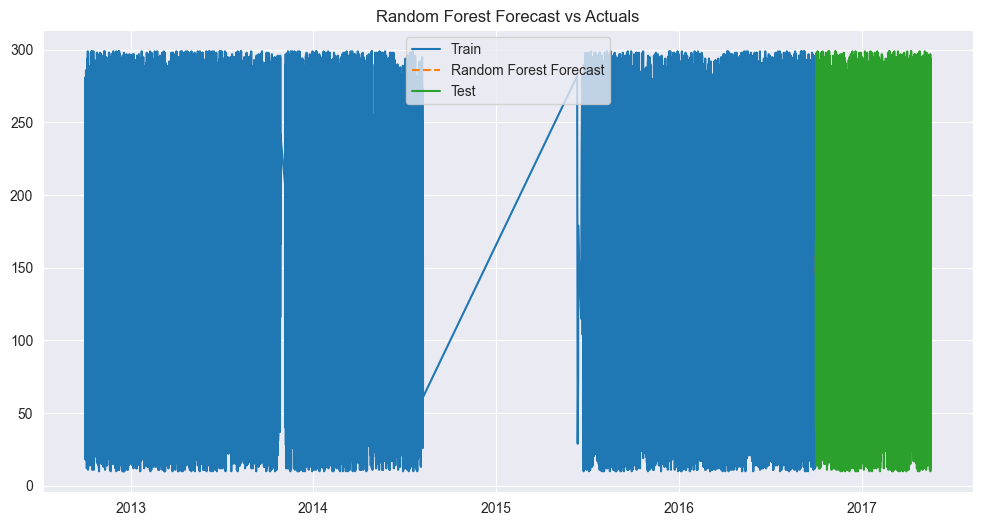

In [6]:
# One-hot encode categorical columns
df_is_holiday = pd.get_dummies(df_raw['is_holiday'], prefix='holiday')
df_weather_type = pd.get_dummies(df_raw['weather_type'], prefix='weather_type')
df_weather_description = pd.get_dummies(df_raw['weather_description'], prefix='weather_desc')

# Concatenate one-hot encoded columns and original dataframe
df_processed = pd.concat([df_raw, df_is_holiday, df_weather_type, df_weather_description], axis=1)

# Drop original non-numeric columns
df_processed.drop(columns=['is_holiday', 'weather_type', 'weather_description'], inplace=True)

# Split data
split_ratio = 0.8
split_point = int(len(df_raw) * split_ratio)
train = df_processed.iloc[:split_point]
test = df_processed.iloc[split_point:]

# Convert dataset to supervised learning format with previous timestep as input
n_lag = 1
n_forecast = 1
series_transformed = series_to_supervised(train, n_lag, n_forecast)

# Separate train sets for endogenous and exogenous variables
endog_train = series_transformed['var1(t)']
exog_train = series_transformed.drop(['var1(t)'], axis=1)

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(exog_train, endog_train)

test_transformed = series_to_supervised(test, n_lag, n_forecast)
endog_test = test_transformed['var1(t)']
exog_test = test_transformed.drop(['var1(t)'], axis=1)

# Forecasting with Random Forest
rf_forecast = rf_model.predict(exog_test)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train.index[n_lag:], endog_train, label='Train')
plt.plot(test.index[n_lag:n_lag+len(rf_forecast)], rf_forecast, label='Random Forest Forecast', linestyle='--')
plt.plot(test.index[n_lag:n_lag+len(endog_test)], endog_test, label='Test')
plt.legend()
plt.title('Random Forest Forecast vs Actuals')
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the Random Forest model
mae = mean_absolute_error(endog_test, rf_forecast)
mse = mean_squared_error(endog_test, rf_forecast)
rmse = np.sqrt(mse)
r2 = r2_score(endog_test, rf_forecast)


mae, mse, rmse, r2


(73.05881908430878,
 7173.241871699511,
 84.69499319144852,
 -0.020506749026953264)